# Gaussian Process

In this notebook, we will implement a Gaussian Process model from scratch.

In [151]:
# import all packages and set plots to be embedded inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.optimize import Bounds
from scipy.linalg import cho_solve
from scipy.linalg import cholesky
from pyDOE import lhs
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

%matplotlib inline

## Correlation length

In [2]:
# Define parameter range and theta values
shift = np.linspace(-2, 2, 100)
thetas = np.array([0.1,1,10])

# Calculate correlation under various theta values
corrs = [np.exp(-theta*shift**2) for theta in thetas]

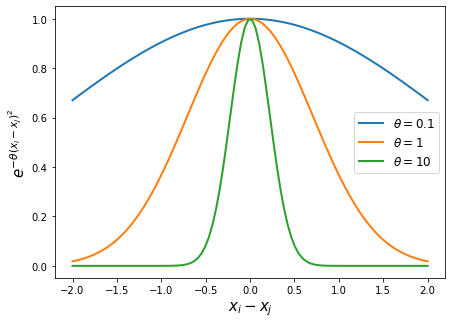

In [3]:
# Visualize results
fig, ax = plt.subplots(figsize=(7,5))

# Define labels
labels = [r'$\theta=0.1$', r'$\theta=1$', r'$\theta=10$']

for i in range(thetas.shape[0]):
    ax.plot(shift, corrs[i], label=labels[i], lw=2)
ax.legend(fontsize=12)
ax.set_xlabel(r'$x_i-x_j$', fontsize=15)
ax.set_ylabel(r'$e^{-\theta (x_i-x_j)^2}$', fontsize=15);
plt.savefig('./images/Correlation_strength')

# Gaussian Process class

In [4]:
X1 = np.array([0,1,2])
X2 = np.array([[3,4,5],[6,7,8]])
K = np.zeros((X1.shape[0],X2.shape[0]))
theta = np.array([2,4,6])

In [5]:
np.sum(theta*(X1-X2)**2,axis=1)

array([108, 432])

In [6]:
K[0,:] = np.sum(theta*(X1-X2)**2,axis=1)

In [7]:
K

array([[108., 432.],
       [  0.,   0.],
       [  0.,   0.]])

In [184]:
class GaussianProcess:
    """A Gaussian Process class that trains and exploits 
    a Gaussian Process model"""
    
    def __init__(self, n_restarts, optimizer):
        """Initialize a Gaussian Process model
        
        Input
        ------
        n_restarts: number of restarts of the local optimizer
        optimizer: algorithm of local optimization"""
        
        self.n_restarts = n_restarts
        self.optimizer = optimizer
        
       
    def Corr(self, X1, X2, theta):
        """Construct the correlation matrix between X1 and X2
        
        Input
        -----
        X1, X2: 2D arrays, shape (n_samples, n_features)
        theta: array, correlation legnths for different dimensions
        
        Output
        ------
        K: the correlation matrix
        """
        K = np.zeros((X1.shape[0],X2.shape[0]))
        for i in range(X1.shape[0]):
            K[i,:] = np.exp(-np.sum(theta*(X1[i,:]-X2)**2, axis=1))
            
        return K
 
       
    def Neglikelihood(self, theta):
        """Likelihood function
        
        Input
        -----
        theta: array, correlation legnths for different dimensions"""
        
        theta = 10**theta    # Correlation length
        n = self.X.shape[0]  # Number of training instances
        one = np.ones((n,1))      # Vector of ones
        
        # Construct correlation matrix
        K = self.Corr(self.X, self.X, theta) + np.eye(n)*1e-10
        inv_K = np.linalg.inv(K)   # Inverse of correlation matrix
        
        # Mean estimation
        mu = (one.T @ inv_K @ self.y)/ (one.T @ inv_K @ one)
        
        # Variance estimation
        SigmaSqr = (self.y-mu*one).T @ inv_K @ (self.y-mu*one) / n
        
        # Compute log-likelihood
        DetK = np.linalg.det(K)
        LnLike = -(n/2)*np.log(SigmaSqr) - 0.5*np.log(DetK)
        
        # Update attributes
        self.K, self.inv_K , self.mu, self.SigmaSqr = K, inv_K, mu, SigmaSqr
        
        return -LnLike.flatten()
        
        
    def fit(self, X, y):
        """GP model training
        
        Input
        -----
        X: 2D array of shape (n_samples, n_features)
        y: 2D array of shape (n_samples, 1)
        """
        
        self.X, self.y = X, y
        lb, ub = -3, 2
        
        # Generate random starting points (Latin Hypercube)
        lhd = lhs(self.X.shape[1], samples=self.n_restarts)
        
        # Scale random samples to the given bounds 
        initial_points = (ub-lb)*lhd + lb
        
        # Create A Bounds instance for optimization
        bnds = Bounds(lb*np.ones(X.shape[1]),ub*np.ones(X.shape[1]))
        
        # Run local optimizer on all points
        opt_para = np.zeros((self.n_restarts, self.X.shape[1]))
        opt_func = np.zeros((self.n_restarts, 1))
        for i in range(self.n_restarts):
            res = minimize(self.Neglikelihood, initial_points[i,:], method=self.optimizer,
                bounds=bnds)
            opt_para[i,:] = res.x
            opt_func[i,:] = res.fun
        
        # Locate the optimum results
        self.theta = opt_para[np.argmin(opt_func)]
        
        # Update attributes
        self.NegLnlike = self.Neglikelihood(self.theta)
        
    
    def predict(self, X_test):
        """GP model predicting
        
        Input
        -----
        X_test: test set, array of shape (n_samples, n_features)
        
        Output
        ------
        f: GP predictions
        SSqr: Prediction variances"""
        
        n = self.X.shape[0]
        one = np.ones((n,1))
        
        # Construct correlation matrix between test and train data
        k = self.Corr(self.X, X_test, 10**self.theta)
        
        # Mean prediction
        f = self.mu + k.T @ self.inv_K @ (self.y-self.mu*one)
        
        # Variance prediction
        SSqr = self.SigmaSqr*(1 - np.diag(k.T @ self.inv_K @ k))
        
        return f.flatten(), SSqr.flatten()
    
    def score(self, X_test, y_test):
        """Calculate root mean squared error
        
        Input
        -----
        X_test: test set, array of shape (n_samples, n_features)
        y_test: test labels, array of shape (n_samples, )
        
        Output
        ------
        RMSE: the root mean square error"""
        
        y_pred, SSqr = self.predict(X_test)
        RMSE = np.sqrt(np.mean((y_pred-y_test)**2))
        
        return RMSE

# Test function

## 1D Test

In [201]:
def Test_1D(X):
    """1D Test Function"""
    
    y = (X*6-2)**2*np.sin(X*12-4)
    
    return y

In [202]:
# Training data
X_train = np.array([0.0, 0.1, 0.2, 0.4, 0.5, 0.6, 0.8, 1], ndmin=2).T
y_train = Test_1D(X_train)

# Testing data
X_test = np.linspace(0.0, 1, 100).reshape(-1,1)
y_test = Test_1D(X_test)

In [203]:
# GP model training
GP = GaussianProcess(n_restarts=10, optimizer='L-BFGS-B')
GP.fit(X_train, y_train)

# GP model predicting
y_pred, y_pred_SSqr = GP.predict(X_test)

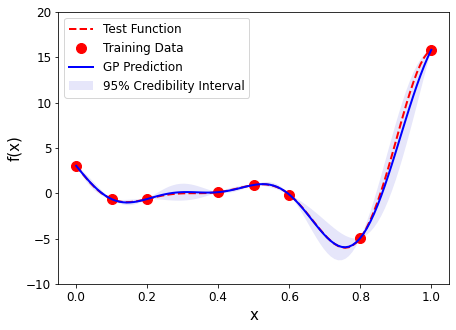

In [204]:
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(X_test,y_test,'r--',linewidth=2,label='Test Function')
ax.plot(X_train,y_train,'ro',markerfacecolor='r', markersize=10, label='Training Data')
ax.plot(X_test,y_pred,'b-', lw=2, label='GP Prediction')
ax.fill_between(X_test.flatten(), y_pred-1.96*np.sqrt(y_pred_SSqr), 
                y_pred+1.96*np.sqrt(y_pred_SSqr),
                facecolor='lavender',label='95% Credibility Interval')
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xlabel('x', fontsize=15)
ax.set_ylabel('f(x)', fontsize=15)
ax.set_ylim([-10,20])
ax.legend(loc="upper left",prop={'size': 12});

## 2D Test

In [207]:
def Test_2D(X):
    """2D Test Function"""
    
    y = (1-X[:,0])**2 + 100*(X[:,1]-X[:,0]**2)**2
    
    return y

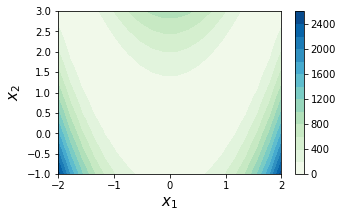

In [208]:
# Testing data
X1 = np.linspace(-2, 2, 20)
X2 = np.linspace(-1, 3, 20)
X1, X2 = np.meshgrid(X1, X2)
X_test = np.hstack((X1.reshape(-1,1), X2.reshape(-1,1)))
y_test = Test_2D(X_test)

fig, ax = plt.subplots(figsize=(5,3))
h = ax.contourf(X1, X2, z, levels=15, cmap='GnBu')
ax.set_xlabel(r'$x_1$', fontsize=15)
ax.set_ylabel(r'$x_2$', fontsize=15)
plt.colorbar(h);

In [209]:
# Training data
sample_num = 30
lb, ub = np.array([-2, -1]), np.array([2, 3])
X_train = (ub-lb)*lhs(2, samples=sample_num) + lb

# Compute labels
y_train = Test_2D(X_train).reshape(-1,1)

In [210]:
# GP model training
pipe = Pipeline([('scaler', MinMaxScaler()), 
         ('GP', GaussianProcess(n_restarts=10, optimizer='L-BFGS-B'))])
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('GP',
                 <__main__.GaussianProcess object at 0x00000230E9DF1910>)])

In [211]:
# GP model predicting
y_pred, y_pred_SSqr = pipe.predict(X_test)

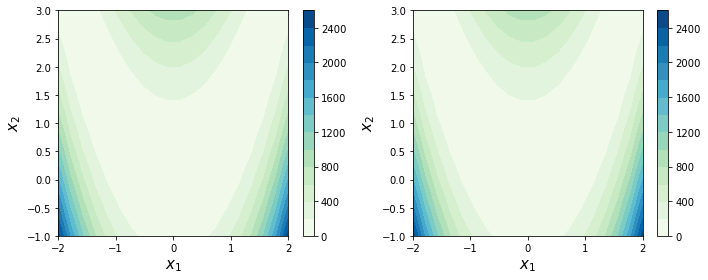

In [212]:
# Post-processing - Contour plot
fig, ax = plt.subplots(1, 2, figsize=(10,4))

for i in range(2):
    h = ax[i].contourf(X_test[:,0].reshape(20,-1), 
                   X_test[:,1].reshape(20,-1), 
                   y_test.reshape(20,-1), levels=15, cmap='GnBu');
    ax[i].set_xlabel(r'$x_1$', fontsize=15)
    ax[i].set_ylabel(r'$x_2$', fontsize=15)
    fig.colorbar(h, ax=ax[i])
plt.tight_layout()

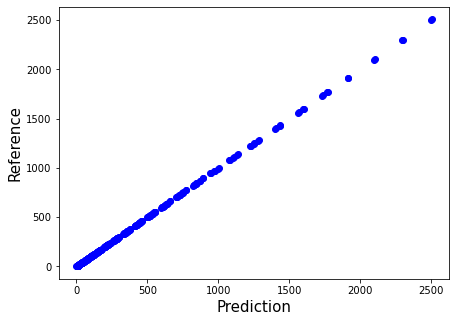

In [213]:
# Post-processing - Contour plot
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(y_pred, y_test, 'ob')
ax.set_xlabel('Prediction', fontsize=15)
ax.set_ylabel('Reference', fontsize=15);

In [214]:
# Assess accuracy score
pipe.score(X_test, y_test)

1.6494108992882868